# Layered HDBSCAN clustering

In [1]:
import numpy as np
from fast_hdbscan import HDBSCAN, LayerClustering

import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (8, 8)})

In [2]:
data_request = requests.get(
    "https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy?raw=true"
)
data = np.load(BytesIO(data_request.content))

The layered clustering algorithm computes HDBSCAN* leaf clusters with an
increasing minimum cluster size threshold. The starting minimum cluster size is
specified by either `base_n_clusters` (binary search to a size that gives the
specified number of leaves) or `base_min_cluster_size` (initial value to use).
Then the `next_cluster_size_quantile` controls which size is used as the next
threshold. The process continues until `min_cluster` leaves remain or the size
increased by a single point. 

Each evaluated minimum cluster size creates a *layer* of cluster labels:

Layer 0 found 39 clusters
Layer 1 found 12 clusters
Layer 2 found 6 clusters
Layer 3 found 3 clusters


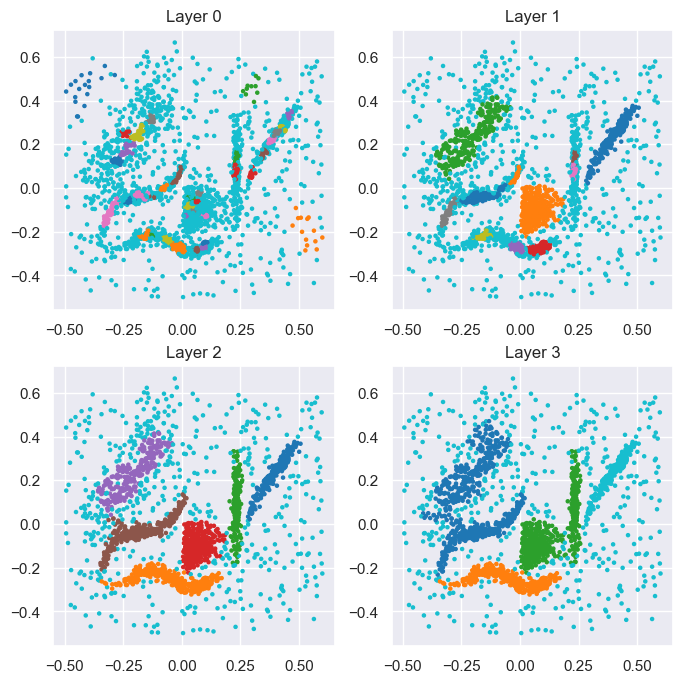

In [3]:
layers = LayerClustering(verbose=True).fit(data)

for i, labels in enumerate(layers.cluster_layers_):
    plt.subplot(2, 2, i + 1)
    plt.scatter(data[:, 0], data[:, 1], c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
    plt.title(f"Layer {i}")
plt.show()

The layer with the fewest noise points is selected as final clustering:

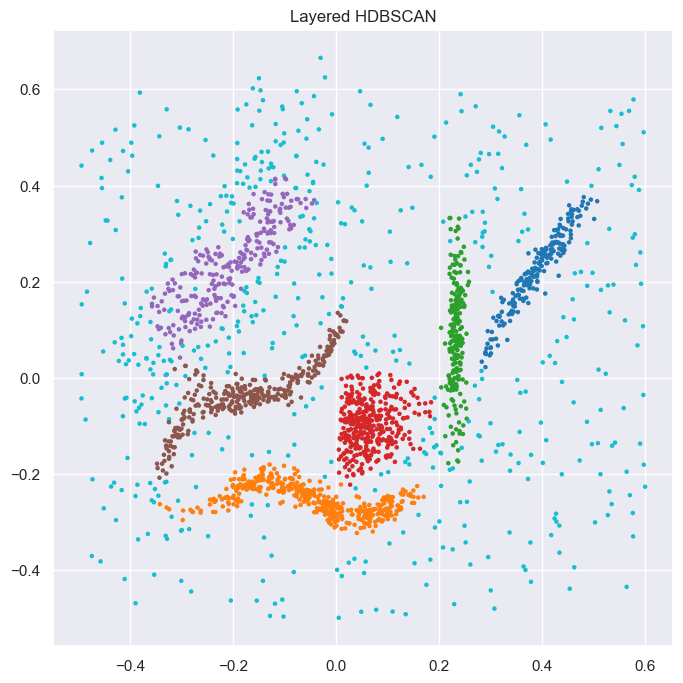

In [4]:
plt.scatter(data[:, 0], data[:, 1], c=layers.labels_ % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title("Layered HDBSCAN")
plt.show()

The clusters in these layers form a leaf-cluster tree, describing how the leaf
clusters merge at larger minimum sizes. The resulting hierarchy has edges across
multiple layers because a leaf's parent may not become a leaf immediately after 
the leaf's death. The resulting hierarchy is also not a binary tree. 

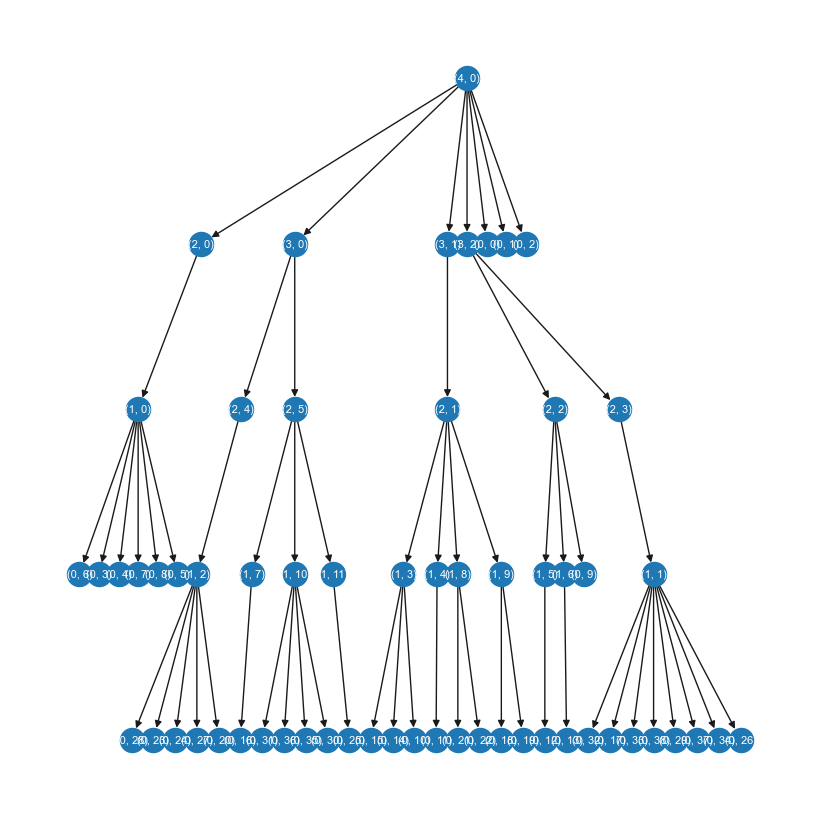

In [5]:
import networkx as nx

g = nx.from_dict_of_lists(layers.cluster_tree_, nx.DiGraph())
pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
nx.draw(g, pos, with_labels=True, font_size=8, font_color="white")
plt.show()

## Exact multi-scale leave tree

It is possible to compute the exact leaf-cluster tree for a moving minimum
cluster size threshold. The idea is equivalent to computing a single linkage
hierarchy from a minimum spanning tree. The procedure below iterates over the
condensed tree leaves in increasing size. In each iteration all leaves with the
smallest size are processed. Their deaths are recorded and the remaining
condensed tree is inspected to determine whether the parent segment has become a
leaf. The process continuous until a single leaf remains and computes the
condensed hierarchy only once! 

In [6]:
# Output
leaves = dict() # {leaf_id: {birth: int, death: int, parent: int}}

# Compute initial condensed tree
min_size = 10
tree = HDBSCAN(min_samples=5, min_cluster_size=min_size).fit(data)._condensed_tree
cluster_tree = tree[tree["child_size"] > 1].copy()

# Find the leaves
n_points = data.shape[0]
n_nodes = cluster_tree["child"].max() + 1
leaf_mask = np.ones(n_nodes - n_points, dtype=np.bool_)
leaf_mask[cluster_tree["parent"] - n_points] = False
for leaf_id in np.where(leaf_mask)[0] + n_points:
    leaves[leaf_id] = dict(birth=int(min_size))

# Iteratively prune lowest size leaves
while leaf_mask.sum() > 1:
    # Extract rows with child leaves
    row_mask = leaf_mask[cluster_tree["child"] - n_points]
    leaf_sizes = cluster_tree["child_size"][row_mask]

    # Find the leaves sharing the smallest size (maybe use a queue instead?)
    leaf_ids = np.where(leaf_mask)[0] + n_points
    min_size = leaf_sizes.min()
    leaf_leaf_idx = np.where(leaf_sizes == min_size)[0]

    # Iterate over all leaves with the smallest size
    for leaf_id in leaf_ids[leaf_leaf_idx]:
        # Find the cluster tree row
        leaf_idx = np.searchsorted(cluster_tree["child"], leaf_id)
        parent = cluster_tree["parent"][leaf_idx]

        # Find the sibling row
        if leaf_idx > 0 and cluster_tree["parent"][leaf_idx - 1] == parent:
            sibling_idx = leaf_idx - 1
        else:
            sibling_idx = leaf_idx + 1
        sibling_id = cluster_tree["child"][sibling_idx]

        # Add the leaf's death and condensed tree parent
        leaves[leaf_id].update(dict(death=int(min_size + 1), parent=int(parent)))
        leaf_mask[leaf_id - data.shape[0]] = False

        # Update the cluster tree to skip the sibling
        cluster_tree["parent"][cluster_tree["parent"] == sibling_id] = parent
        cluster_tree["parent"][sibling_idx] = sibling_id
        cluster_tree["parent"][leaf_idx] = leaf_id

        # Check if sibling is a to-be-processed leaf
        if leaf_mask[sibling_id - data.shape[0]]:
            # Also add a death for the sibling
            leaves[sibling_id].update(dict(death=int(min_size + 1), parent=int(parent)))
            leaf_mask[sibling_id - data.shape[0]] = False
            # Add a birth for the parent
            leaves[parent] = dict(birth=int(min_size + 1))
            leaf_mask[parent - data.shape[0]] = True

# Use first cluster tree ancestor that becomes a leave as parent
cluster_tree = tree[tree["child_size"] > 1]
for child, attrs in leaves.items():
    if 'parent' not in attrs:
        continue
    parent = attrs["parent"]
    while parent not in leaves:
        idx = np.searchsorted(cluster_tree["child"], parent)
        parent = int(cluster_tree["parent"][idx])
    attrs["parent"] = parent

Computing the number of noise points at each minimum cluster size is trivial.
Births reduce the number of noise points, deaths increase the number of noise
points. Essentially this implements a group-by-sum operation.

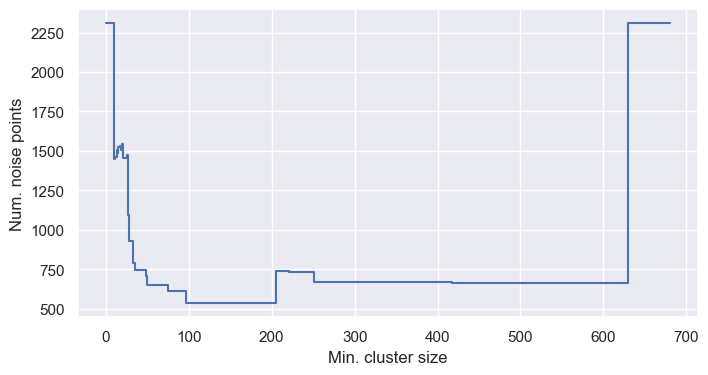

In [ ]:
# List the number of points in each leaf birth and death
min_sizes = []
events = []
for leaf_id, attrs in leaves.items():
    tree_idx = np.searchsorted(cluster_tree["child"], leaf_id)
    item_size = cluster_tree["child_size"][tree_idx]
    min_sizes.append(attrs["birth"])
    events.append(-item_size)
    if "death" in attrs:
        min_sizes.append(attrs["death"])
        events.append(item_size)

# Sort the events by the minimum cluster size
min_sizes = np.asarray(min_sizes)
events = np.asarray(events)
order = np.argsort(min_sizes, kind="stable")
min_sizes = min_sizes[order]
events = events[order]

# Compute cumulative sum and extract the last event for each minimum size
noise_trace = np.cumsum(events) + data.shape[0]
indices = np.nonzero(np.diff(min_sizes) != 0)[0]
min_size_list = min_sizes[indices].tolist()
noise_trace_list = noise_trace[indices].tolist()

# Convert to square curve
inf_value = int(min_size + 1 + 50)  # or extracts max death from leaves
noise_trace_sizes = np.vstack(
    (
        np.asarray([0] + min_size_list + [min_sizes[-1]]),
        np.asarray(min_size_list + [min_sizes[-1], inf_value]),
    )
).T.reshape(-1)
noise_trace_points = np.vstack(
    (
        np.asarray([n_points] + noise_trace_list + [n_points]),
        np.asarray([n_points] + noise_trace_list + [n_points]),
    )
).T.reshape(-1)

plt.figure(figsize=(8, 4))
plt.plot(noise_trace_sizes, noise_trace_points)
plt.xlabel("Min. cluster size")
plt.ylabel("Num. noise points")
plt.show()

Computing condensed-tree stability for leaf-clusters at the different minimum
cluster sizes:

- only compute persistence between min_cluster_size birth and death.
- consider points in all cluster_tree child segments.
- compute persistence as $\lambda_{enter} - \lambda_{death}$
- compute stability as the sum of persistences for the points in a segment
  - the initial min cluster size points enter at the density at which the
    segment meets the minimum cluster size threshold!
  - other points enter at their density in the condensed tree.

In [8]:
def bf_children(cluster_tree, segment_id):
    """Extracts points in the condensed tree below the leaf_id segment."""
    to_process = [segment_id]
    result = []

    while len(to_process) > 0:
        result.extend(to_process)
        to_process = cluster_tree["child"][
            np.isin(cluster_tree["parent"], to_process, assume_unique=True)
        ]
    return result


def compute_leaf_stability(leaf_id, leaf, cluster_tree, points_tree):
    """Computes the lambda persistence curve of a leaf-cluster tree segment."""
    # Find the cluster's points in the condensed tree and list min, max size and
    # death density.
    min_size = leaf["birth"]
    if "death" in leaf:
        max_size = leaf["death"]
        segment_ids = bf_children(cluster_tree, leaf_id)
        segment_points = points_tree[np.isin(points_tree["parent"], segment_ids)]
        lambda_death = cluster_tree["lambda_val"][cluster_tree["child"] == leaf_id][0]
    else:
        max_size = points_tree.shape[0]
        segment_points = points_tree
        lambda_death = 0

    # Find lambda values for points entering the cluster within its size range.
    # The partition lets us sort just the points in the size range.
    leaf_size = segment_points.shape[0]
    indices = [leaf_size - max_size + 1, leaf_size - min_size + 1]
    lambdas = np.partition(segment_points["lambda_val"], indices)
    lambda_births = np.sort(lambdas[indices[0] : indices[1]])[::-1]

    # Create arrays for use with plt.pcolormesh
    #   min cluster size
    birth_size = np.arange(min_size, max_size)
    #   persistence = lambda_births - lambda_death
    persistences = lambda_births - lambda_death
    #   stability = min_size * (birth - death) + sum(enter - death)
    stability = (birth_size - 1) * persistences + np.cumsum(persistences[::-1])[::-1]
    return stability

points_tree = tree[tree["child_size"] == 1]
for leaf_id, leaf in leaves.items():
    leaf['stability'] = compute_leaf_stability(leaf_id, leaf, cluster_tree, points_tree)

Aggregate stabilities over all leaf-clusters.

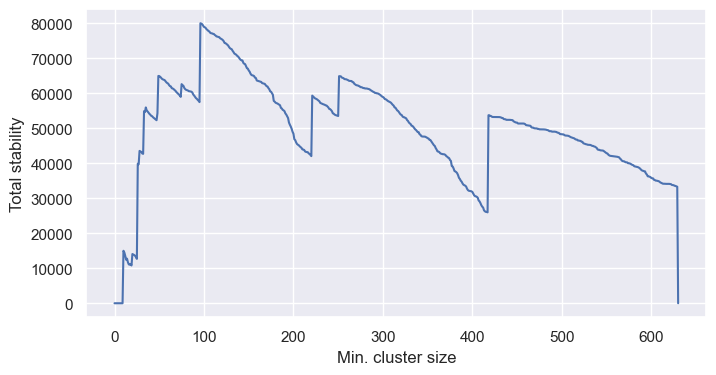

In [9]:
max_death = max(leaf.get("death", 0)+1 for leaf in leaves.values())
total_stability = np.zeros(max_death)
for leaf in leaves.values():
    if "death" in leaf:
        stability = leaf['stability']
        min_size = leaf["birth"]
        max_size = min_size + stability.shape[0]
        total_stability[min_size:max_size] += stability

fig = plt.figure(figsize=(8, 4))
plt.plot(total_stability)
plt.ylabel("Total stability")
plt.xlabel("Min. cluster size")
plt.show()

The optimal minimum cluster size has the lowest number of noise points or
highest total stability (equivalent in this case), finding the same labelling as
`LayerClustering`:

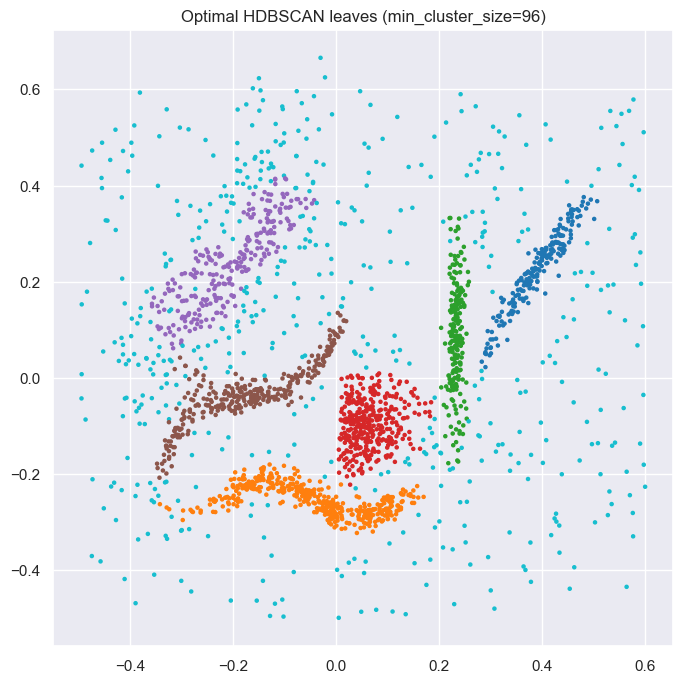

In [10]:
from fast_hdbscan.cluster_trees import (
    get_cluster_label_vector,
    get_point_membership_strength_vector,
)

# best_size = min_sizes[np.argmin(noise_trace)]
best_size = np.argmax(total_stability)
select_leaves = [
    leaf_id
    for leaf_id, attrs in leaves.items()
    if attrs["birth"] <= best_size and attrs.get("death", np.inf) > best_size
]

labels = get_cluster_label_vector(tree, select_leaves, cluster_selection_epsilon=0.0, n_samples=n_points)
probs = get_point_membership_strength_vector(tree, select_leaves, labels)

plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title(f"Optimal HDBSCAN leaves (min_cluster_size={best_size})")
plt.show()

Plotting the leaf-cluster tree with `plt.pcolormesh`:

In [13]:
import warnings
from matplotlib.collections import LineCollection

# Depth first traversal to order the leaf clusters
def df_leaf_order(children, id):
    order = [id]
    if id in children:    
        for child in sorted(children[id], key=lambda x: leaves[x]["death"], reverse=True):
            order += df_leaf_order(children, child)
    return order


def compute_x_coords(leaves, root):
    # Convert to directed graph
    children = dict()
    for leaf_id, attrs in leaves.items():
        if "parent" not in attrs:
            continue
        parent = attrs["parent"]
        if parent not in children:
            children[parent] = []
        children[parent].append(leaf_id)    

    # List x-coordinates
    return {
        leaf: i
        for i, leaf in enumerate(df_leaf_order(children, root))
    }


class LeafClusterTree:
    def __init__(self, leaves, total_stability):
        self.leaves = leaves
        self.total_stability = total_stability
        self.max_stability = max(leaf["stability"].max() for leaf in leaves.values())
        self.max_total_stability = total_stability.max()

    def as_pandas(self):
        import pandas as pd

        return pd.DataFrame.from_dict(self.leaves, orient='index')

    def plot(
        self,
        inf_padding=0.1,
        min_width=0.05,
        max_width=4,
        cmap="viridis",
        colorbar_kws=None,
    ):
        if colorbar_kws is None:
            colorbar_kws = dict()
        max_width = (max_width - min_width) / 2
        max_death = max(leaf.get("death", 0) for leaf in self.leaves.values())
        inf_value = round((1 + inf_padding) * max_death)
        x_coords = compute_x_coords(leaves, min(leaves.keys()))

        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_id], leaf["death"]),
                        (x_coords[leaf_id], leaves[leaf["parent"]]["birth"]),
                    ]
                    for leaf_id, leaf in self.leaves.items()
                    if "death" in leaf
                ],
                linewidths=0.5,
                linestyle="--",
                color="black",
            )
        )
        plt.gca().add_collection(
            LineCollection(
                [
                    [
                        (x_coords[leaf_id], leaves[leaf["parent"]]["birth"]),
                        (x_coords[leaf["parent"]], leaves[leaf["parent"]]["birth"]),
                    ]
                    for leaf_id, leaf in self.leaves.items()
                    if "parent" in leaf
                ],
                linewidths=0.5,
                linestyle="-",
                color="black",
            )
        )

        for leaf_id, leaf in leaves.items():
            stability = leaf["stability"]
            min_size = leaf["birth"]
            max_size = min(min_size + stability.shape[0], inf_value)

            # Y dimension:
            sizes = np.arange(min_size, max_size)
            # X dimension:
            stability = stability[: max_size - min_size]
            xs = x_coords[leaf_id] + np.asarray([[-min_width / 2], [min_width / 2]])
            widths = xs + stability / self.max_stability * max_width * np.array(
                [[-1], [1]]
            )
            # Color dimensions:
            total_stability = self.total_stability[min_size:max_size]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                bar = plt.pcolormesh(
                    widths,
                    np.broadcast_to(sizes, (2, len(sizes))),
                    np.broadcast_to(total_stability, (2, len(sizes))),
                    vmin=0,
                    vmax=self.max_total_stability,
                    edgecolors="none",
                    linewidth=0,
                    cmap=cmap,
                )
        if "fraction" in colorbar_kws:
            bbox = plt.gca().get_window_extent()
            ax_width, ax_height = bbox.width, bbox.height
            colorbar_kws["aspect"] = ax_height / (ax_width * colorbar_kws["fraction"])
        plt.colorbar(bar, label="Total stability", **colorbar_kws)

        plt.xticks([])
        plt.ylabel("Min. cluster size")
        xlim = plt.xlim()
        plt.xlim([xlim[0] - 0.02 * xlim[1], 1.02 * xlim[1]])
        plt.ylim([0, inf_value])

Icicle widths indicate the cluster's stability at that minimum cluster size.
Icicle color indicates the total stability over all clusters at that minimum
cluster size.

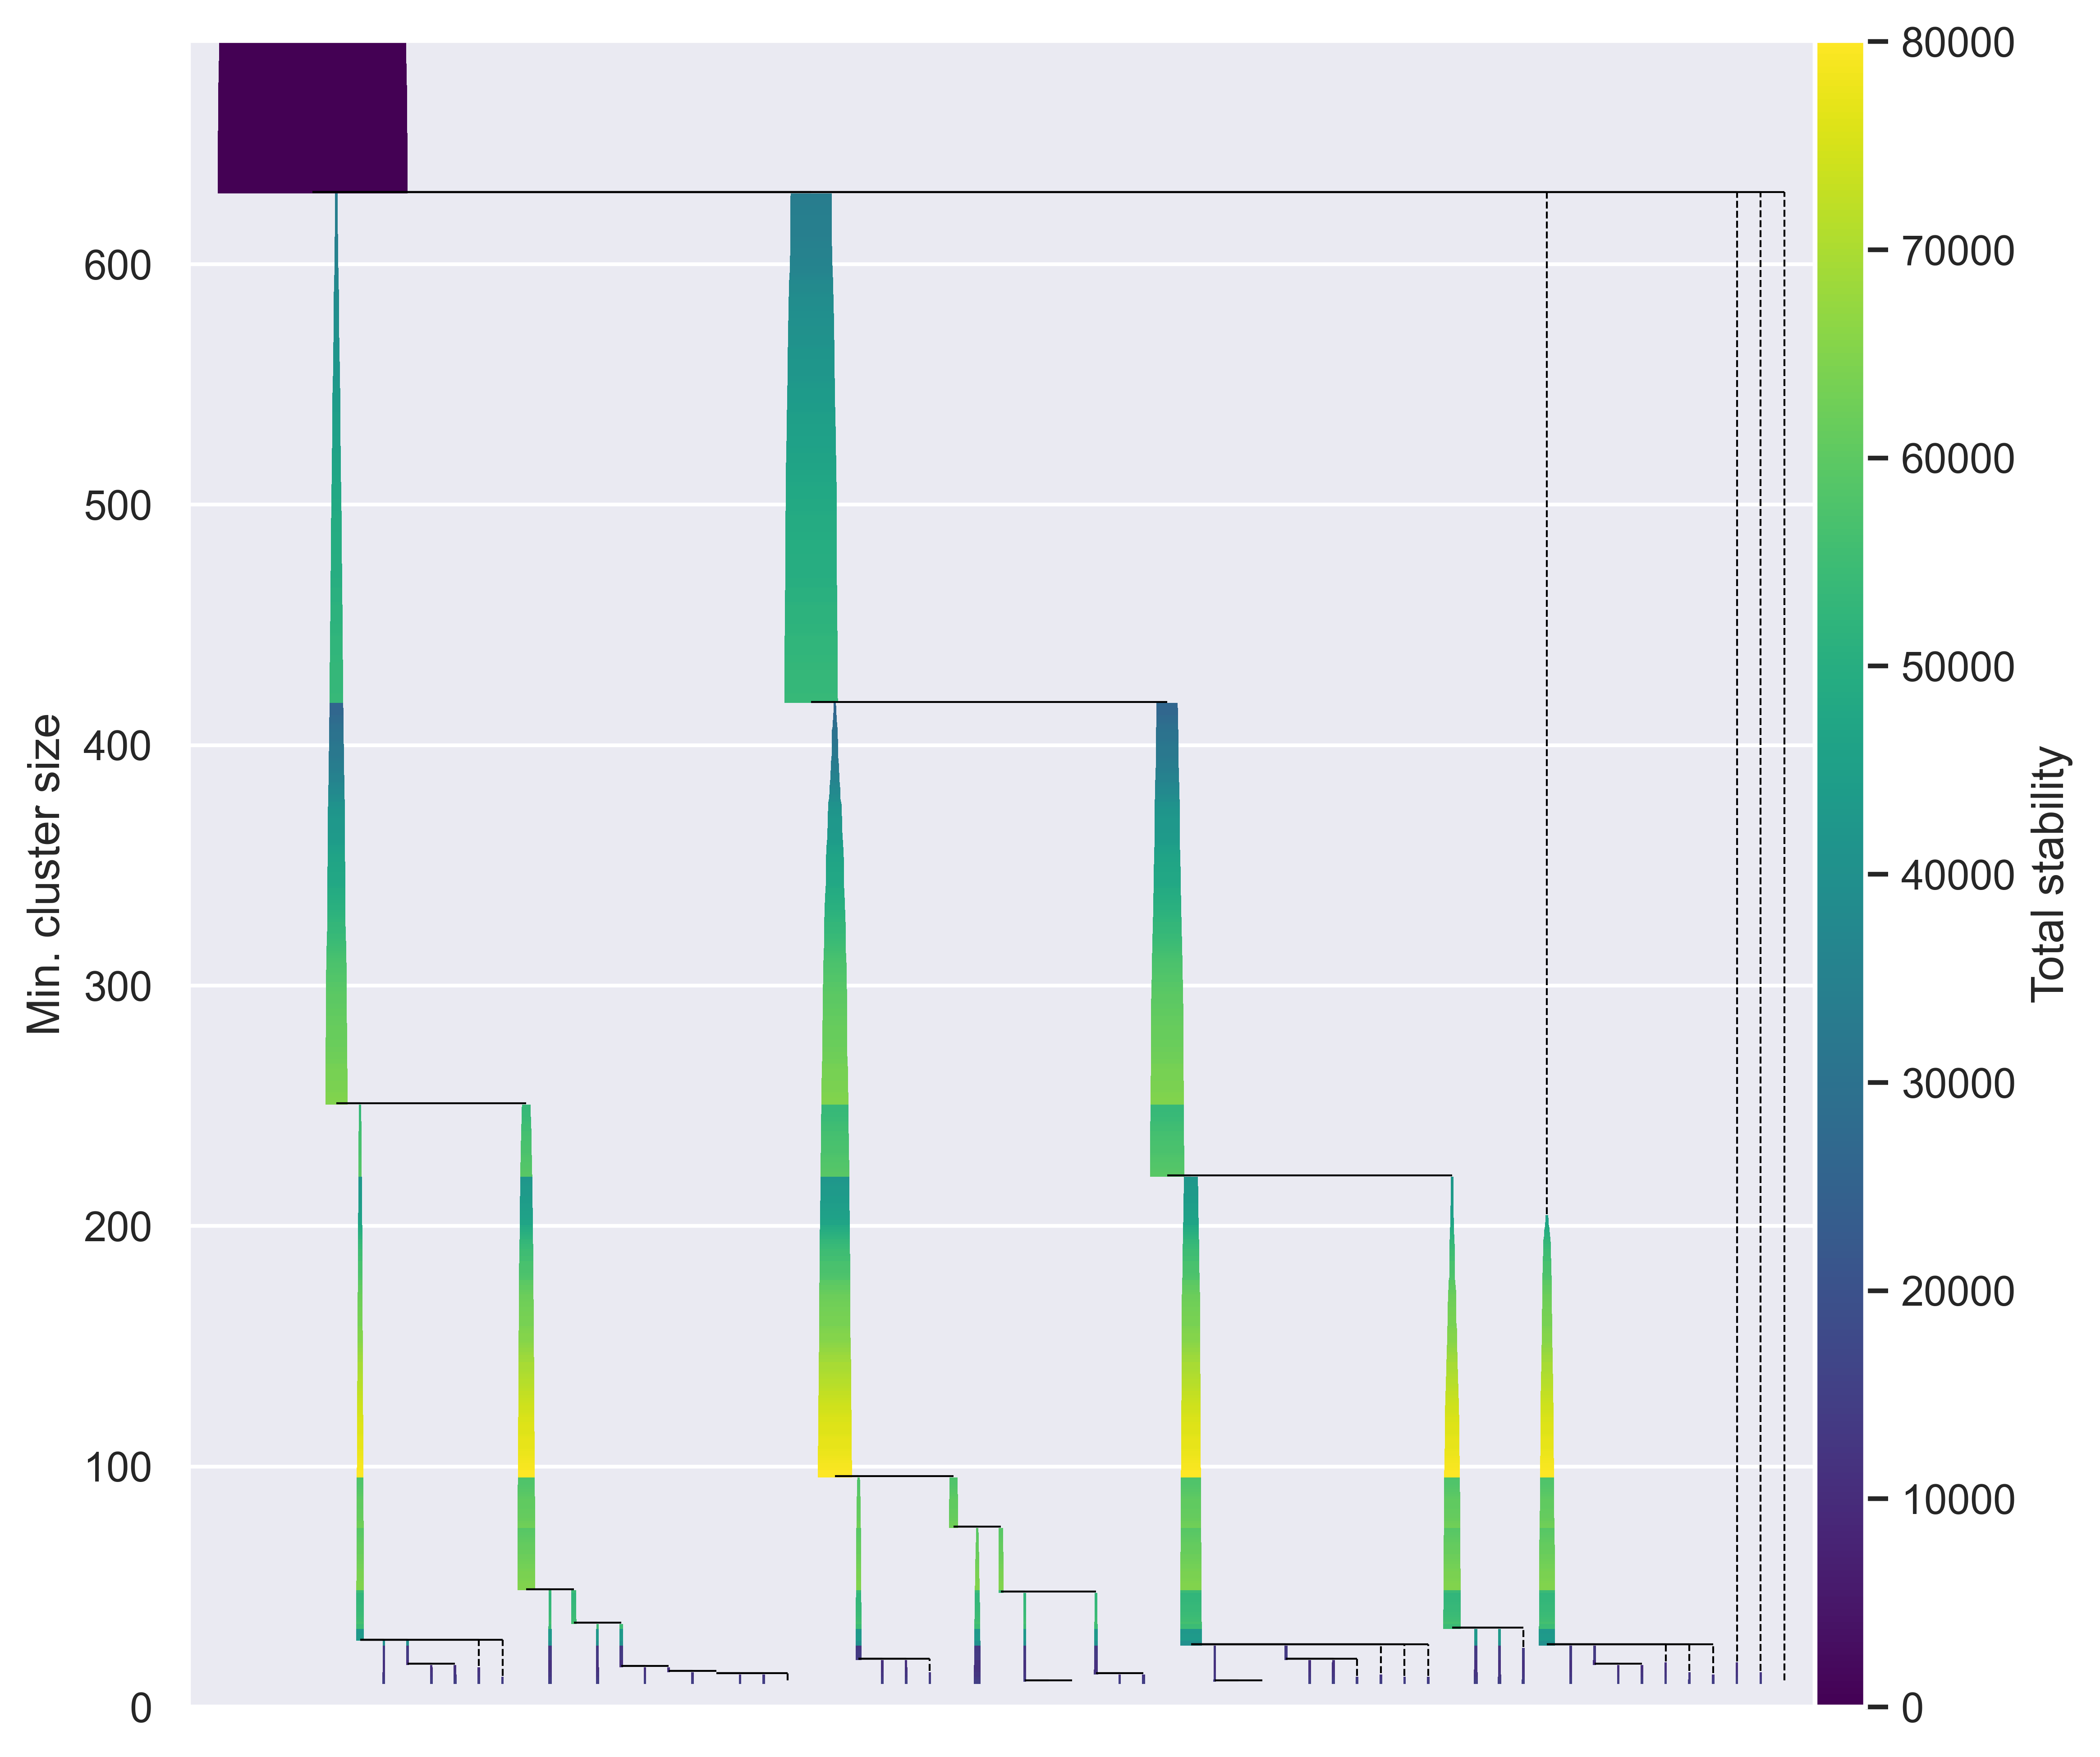

In [14]:
plt.figure(dpi=600)
tree_class = LeafClusterTree(leaves, total_stability)
tree_class.plot(colorbar_kws=dict(pad=0, fraction=0.03))
plt.show()

A straight min_cluster_size cut seems most appropriate for this tree, regardless
of the measure being optimized. Maximizing the total stability works and relates
to minimizing the number of noise points. The total stability at a particular
minimum cluster size is a sum of density persistences over all points in the
clusters at that threshold. That signal contains the noise point trace. In
addition, the stability of each leaf-cluster is always largest at its birth. I
think that means that the total stability has a maximum when the number of noise
points is minimal. Maybe there are weird cases where it does not hold?

What about EOM-style cluster selection? That approach would always include a
segment in all paths from the root. This includes very small and low-stability
leaves:

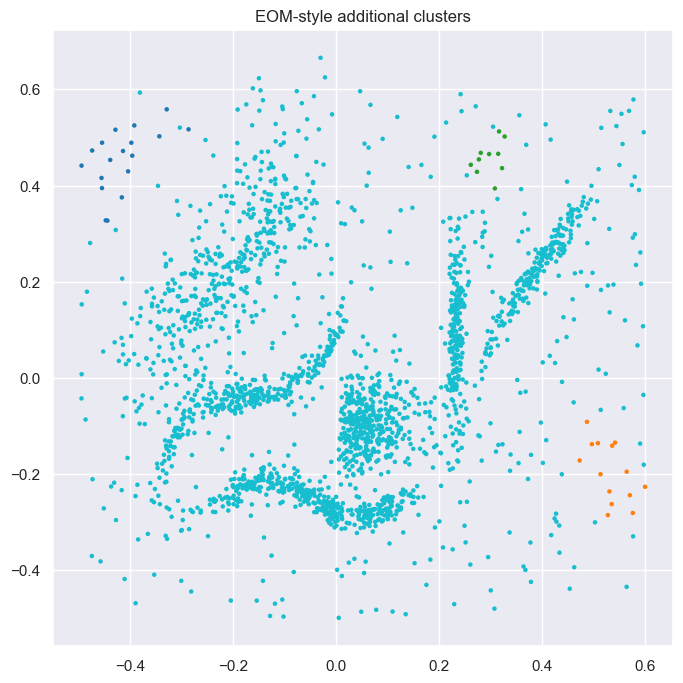

In [ ]:
root = tree['parent'][0]
extra_select_leaves = [
    leaf_id
    for leaf_id, leaf in leaves.items()
    if leaf_id != root and leaf["parent"] == root and leaf["death"] < best_size
]

labels = get_cluster_label_vector(
    tree, extra_select_leaves, cluster_selection_epsilon=0.0, n_samples=n_points
)
probs = get_point_membership_strength_vector(tree, extra_select_leaves, labels)

plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title(f"EOM-style additional clusters")
plt.show()